# Lab 3 — dimensionality reduction

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter
from collections import OrderedDict

%matplotlib inline
plt.style.use("ggplot")

In [2]:
!hdfs dfs -cat /ix/ml-20m/genome-tags.txt | tail -n 2
!hdfs dfs -cat /ix/ml-20m/genome-scores.txt | tail -n 2

{"tagId": 1127, "tag": "zombie"}
{"tagId": 1128, "tag": "zombies"}
{"relevance": 0.11449999999999999, "tagId": 1127, "movieId": 131170}
{"relevance": 0.02174999999999999, "tagId": 1128, "movieId": 131170}


# 1) Statistic

In [3]:
def load_data():
    tag_name = sc.textFile("/ix/ml-20m/genome-tags.txt").map(json.loads)
    tag_score = sc.textFile("/ix/ml-20m/genome-scores.txt").map(json.loads)
    tag2name = dict(tag_name.map(itemgetter("tagId", "tag")).collect())
    print ("There are {e} elements in RDD tag_name".format(e = tag_name.count()))
    print ("There are {e} elements in RDD tag_score".format(e = tag_score.count()))

    print ("There are {x} tags".format(x = tag_name.count()))
    movies = tag_score.map(lambda x : x['movieId'])
    setMovies = set(movies.collect())
    print ("There are {x} movies".format(x = len(setMovies)))
    return tag_name, tag_score, tag2name, setMovies, tag_name.count(), len(setMovies)

tag_name, tag_score, tag2name, setMovies, M, N = load_data()

There are 1128 elements in RDD tag_name
There are 11709768 elements in RDD tag_score
There are 1128 tags
There are 10381 movies


# 2) Collect data and perform Dimensionality Reduction

In [4]:
# Map movie ID into a range continuously
movieId2index = {}
for index, movieId in enumerate(setMovies):
    movieId2index[movieId] = index

In [5]:
def create_matrix(nbMovie, nbTag):
    matrix = np.zeros((nbMovie,nbTag))
    data = tag_score.map(lambda x : (str(x['movieId'])+","+str(x['tagId']),x['relevance']))
    for x in data.collect():
        movieId, tagId = x[0].split(",")
        matrix[movieId2index[int(movieId)] , int(tagId) - 1] = x[1]
    return matrix
matrix = create_matrix(N,M)

In [10]:
def standardize(x):
    """Standardize the original data set."""
    mean_x = np.mean(x, axis=0)
    x = x - mean_x
    std_x = np.std(x, axis=0)
    x = x / std_x
    return x, mean_x, std_x


def de_standardize(x, mean_x, std_x):
    """Reverse the procedure of standardization."""
    x = x * std_x
    x = x + mean_x
    return x

In [34]:
def eigens(matrix):
    """Return eigenvalue, eigenvector decreasing order"""
    nbMovie , nbTag = matrix.shape
    mean_x = np.mean(matrix, axis=0)
    matrix = matrix - mean_x
    covariance_matrix = matrix.T @ matrix / nbMovie
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    return covariance_matrix, eigenvalues, eigenvectors

In [31]:
def compute_mse_matrix(x, x_):
    return (np.mean(np.square(x-x_)))

In [46]:
"""k = k first principle components"""
def dimensionality_reduction(matrix, k):
    covariance_matrix, eigenvalues, eigenvectors = eigens(matrix)
    M, _ = eigenvectors.shape
    new_features = eigenvectors[:k]
    data_reduction = new_features @ matrix.T # data one new space (k eigenvectors)
    new_matrix = (new_features.T @ data_reduction).T
    print ("With k = {i}, we have an error of {e}".format(i=k,e=compute_mse_matrix(matrix,new_matrix)))
    
    return new_matrix

In [47]:
for x in range(1,10):
    dimensionality_reduction(matrix, x)

True
With k = 1, we have an error of 0.037321428172915797
True
With k = 2, we have an error of 0.037289963267396864
True
With k = 3, we have an error of 0.03726921214901631
True
With k = 4, we have an error of 0.037246133687723185
True
With k = 5, we have an error of 0.03723076986310604
True
With k = 6, we have an error of 0.037217552993347204
True
With k = 7, we have an error of 0.03720510146408689
True
With k = 8, we have an error of 0.03719336284798926
True
With k = 9, we have an error of 0.03716090109696655


## Exercise 3.1

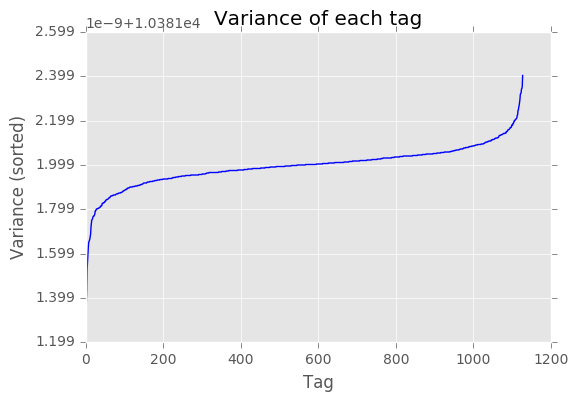

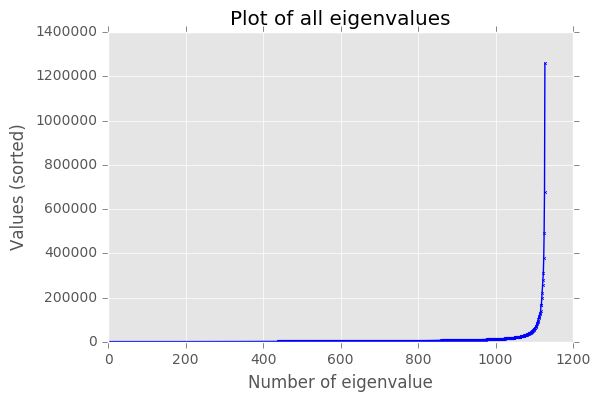

In [69]:
def plot_plot():
    x, mean_x, std_x = standardize(matrix)
    covariance_matrix, eigenvalues, eigenvectors = eigens(x)
    variance = [covariance_matrix[a,a] for a in range(M)]
    variance = np.sort(variance)
    eigenvalues = np.sort(eigenvalues)
    
    """Plot the variance of each dimension"""
    plt.figure()
    plt.plot(variance, color='b')
    plt.title("Variance of each tag")
    plt.xlabel("Tag")
    plt.ylabel("Variance (sorted)")
    plt.show()
    
    """Plot the eigenvalues"""
    plt.figure()
    plt.plot(eigenvalues, color='b',ms=2,marker='x')
    plt.title("Plot of all eigenvalues")
    plt.xlabel("Number of eigenvalue")
    plt.ylabel("Values (sorted)")
    plt.show()
plot_plot()

In [45]:
def capture_variability(matrix, quantity):
    #x, mean_x, std_x = standardize(matrix)
    covariance_matrix, eigenvalues, eigenvectors = eigens(matrix)
    eigenvalues = eigenvalues/np.sum(eigenvalues)
    nbDirection = 0
    captureVariance = 0
    while (captureVariance < quantity):
        captureVariance += eigenvalues[nbDirection]
        nbDirection += 1
    print ("Number of principle directions needed for capturing {q} the variability of the data is {v}".format(q = quantity,v=nbDirection))

capture_variability(matrix,2/3)   

True
Number of principle directions needed for capturing 0.6666666666666666 the variability of the data is 37


#### Dimensionality reduction tries to capture the maximum variability of the data (also mean minimum error when we want to reconstruct data). The first principle eigenvector (which corresponds to the highest eigenvalue) gives the direction of highest variability that we can capture and so on...

## Exercice 3.2

In [14]:
def find_top_tags(direction):
    indexes_sorted = np.argsort(direction)
    print ("*****Top 10 tags that have the HIGHEST coordinates in that direction: *****")
    for i in indexes_sorted[::-1][:10]:        
        print(tag2name[i])
    print ("*****Top 10 tags that have the LOWEST coordinates in that direction: *****")
    for i in indexes_sorted[:10]:
        print(tag2name[i])

In [76]:
def concepts(matrix, k):
    x, mean_x, std_x = standardize(matrix)
    covariance_matrix, eigenvalues, eigenvectors = eigens(x)
    dimension = len(eigenvalues)
    principle_directions = eigenvectors[:k]
    projection = principle_directions@matrix.T
    for i in range (k):
        string = "The first direction: " if i==0 else ("The second direction: " if i==1 else 
                ("The third direction: " if i==2 else ("The fourth direction: " if i==3 else ("The fifth direction"))))
        print("-------",string,"-------")
        find_top_tags(principle_directions[i,])
    
concepts(matrix, 5)


------- The first direction:  -------
*****Top 10 tags that have the HIGHEST coordinates in that direction: *****
anime
moving
minnesota
boat
mexico
allegory
aviation
cartoon
art house
frightening
*****Top 10 tags that have the LOWEST coordinates in that direction: *****
artificial intelligence
argentina
bizarre
archaeology
monster
italian
manipulation
homophobia
death penalty
bad cgi
------- The second direction:  -------
*****Top 10 tags that have the HIGHEST coordinates in that direction: *****
manipulation
mtv
obsession
paranoid
radio
passionate
movielens top pick
original
multiple storylines
literature
*****Top 10 tags that have the LOWEST coordinates in that direction: *****
mexico
moving
minnesota
loneliness
movie business
music
military
murder
artificial intelligence
robot
------- The third direction:  -------
*****Top 10 tags that have the HIGHEST coordinates in that direction: *****
gunfight
hacking
adultery
guns
writer's life
vietnam
truman capote
hackers
time
animated
*****

#### In this case, we use the five first pricipal components and try to summarise all the tags properties that strongly differ accross tags. The main thing is that we are not interesting to the property that is the same fo most of the tags, PCA looks for properties that give us the maximun variability across tags as possible. So here, these concepts are the summary of the tags

In [78]:
def write_tag_coordinates(matrix):
    x, mean_x, std_x = standardize(matrix)
    covariance_matrix, eigenvalues, eigenvectors = eigens(x)
    dimension = len(eigenvalues)
    principle_directions = eigenvectors[:5]
    data = {}
    for tagId in range(dimension):
        array = principle_directions.T[tagId]
        data[tag2name[tagId+1]] = [array[0],array[1],array[2],array[3],array[4]]
    with open('tag-coordinates.txt', 'w') as f:
        json.dump(data, f)
write_tag_coordinates(matrix)

## Exercice 3.3

In [6]:
import pickle
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.io import output_notebook
from bokeh.models import Range1d
with open("selected-movies.pickle", "rb") as f:
    sel_movs = pickle.load(f, encoding="utf8")
data_= sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)

In [7]:
def visualization(x_, y_, names_, colors_):
    output_notebook()
    colors = ["#%02x%02x%02x" % (int(r*255),int(r*255),int(r*255)) for r in colors_]
    source = ColumnDataSource(
        data=dict(
                    x=x_,
                    y=y_,
                    label=names_
                 )
    )
    TOOLS="pan,wheel_zoom,box_zoom,reset,hover,previewsave"
    p = figure(title="Tomatoes score for some movies, color is white if score = 1 and black if score = 0", tools=TOOLS)
    p.circle('x', 'y', fill_color=colors, size=20, source=source)

    hover =p.select(dict(type=HoverTool))
    hover.tooltips = OrderedDict([("name", "@label"),])
    p.x_range = Range1d(-.75, .5)
    p.y_range = Range1d(-1.5, 0)
    show(p)

In [13]:
def movie_visualization(matrix, sel_movs):
    x, mean_x, std_x = standardize(matrix)
    covariance_matrix, eigenvalues, eigenvectors = eigens(x)
    principle_directions = eigenvectors[:2]
    projection = principle_directions @ matrix.T
    movies_to_plot = [(projection.T[movieId2index[x[0]]],x[2]) for x in sel_movs]
    movie2genres = []
    for movie in sel_movs:
        genres = data_.filter(lambda x : x['movieId']==movie[0]).map(lambda x : x['genres']).collect()
        movie2genres.append((movie[1],genres))
    x = [x[0][0] for x in movies_to_plot]
    y = [x[0][1] for x in movies_to_plot]
    colors = [x[1] for x in movies_to_plot]
    visualization(x, y, movie2genres, colors)
movie_visualization(matrix, sel_movs)

Loading BokehJS ...

##### PCA separates movies with low,  from movies with high Tomatoes score. Hence movies are grouped together according to their Tomatoes score. 

